In [1]:
from urllib import request
import zipfile
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error

### 1. Get dataset

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### 2. Prepare error metrics: RMSE
Your Task:
1. Prepare 2 functions that will calculate the goodness of fit: RMSE and HR@n
2. RMSE:
$RMSE(R,\hat{R})=\sqrt{1/n \sum{(r - \hat{r})^2}}$ <br/>
$n\  - \text{# ratings in Y}$ <br/>
$R\  - \text{ground true ratings}$ <br/>
$\hat{R}\ - \text{predictions of your model}$ <br/>

In [3]:
def rmse(R,R_hat,index):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         index (np.array): index of R and R_hat for which RMSE needs to be calculated
    returns:
         RMSE value
        
    """
    #YOUR TASK: implement RMSE
    X = np.multiply((R-R_hat), index)
    Y = np.sum(np.multiply(X,X))
    Z= np.sum(index)
    return np.sqrt(Y / Z)

### 3. Prepare error metrics HR@n (please solve after you implement MF with ALS)

Your task: write a function that calculates HR@n

HR(u)@n for a single user u is calculated when the number of recommended items for that user is n. If out of n recommended items m (m<=n) were consumed by user then:

#### $HR@n(u) = \frac{m}{n}$ <br/>

Overall HR@n is just an average over all users:
#### $HR@n = \frac{1}{n_u} \sum{\frac{m}{n}}$ <br/>
 
be careful with caveats with HR!

In [4]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         R_exclude (np.array): rank 2 matrix of ratings to be excluded i.e. if R_exclude[u,i]>0 then item i for user u has to be excluded from HR calculation (e.g. it was used for training)
         n (int): length of recommendation
    returns:
         RMSE value
        
    """
    #YOUR TASK: implement HR@n function

    return hr_total

### 4. Main part: iplementation of ALS

Your task: implement a ALS MF recommender. This is iterative algorithm and MF_ALS class implements it.
#### 1. We will factorise rating matrix R so that $R\approx \hat{R}= XY^T$ , 
#### 2. Every step of this iteration calculates X and Y which are in fact embeedings for users (X) and items (Y) and there will be n_iters iterations
#### 3. $X \in R^{n_u\ x\ \text{n_factors}}$ $Y \in R^{n_i\ x\ \text{n_factors}}$ X, Y can be initialised uniformlly [0,1]
#### 4. We want it to be a regularised version of ALR (reg>0), but you can start without it for simplicity
#### 5. After every iteration we want to log the RMSE and HR@n using functions that you have developed above


In [5]:
class MF_ALS:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test,n=10):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        # YOUR TASKS 0: initialise X, Y (user and items factors)
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_rmse_record  = []
        self.train_rmse_record = []  
        self.test_hr = []
        self.train_hr = []
        self.hr_n = n 
        for _ in range(self.n_iters):
            # YOUR TASKS 1: call _als_step to get updated values for user and item embeeding tables
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)       
            # YOUR TASKS 2: get predictions i.e. R_hat
            predictions = self.predict()
            test_rmse = self.compute_rmse(test, predictions)
            train_rmse = self.compute_rmse(train, predictions)
            test_hr = self.compute_hr_at_n(test,predictions,train,n)
            train_hr = self.compute_hr_at_n(train,predictions,np.zeros_like(train),n)
            self.test_rmse_record.append(test_rmse)
            self.train_rmse_record.append(train_rmse)
            self.test_hr.append(test_hr)
            self.train_hr.append(train_hr)
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        # YOUR TASKS 1.1: callculate update for X/Y depending on parameters. WHITEBOARD FIRST!
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        # YOUR TASKS 2.2: get predictions i.e. R_hat
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_rmse(R, R_hat):
        """ignore zero terms prior to comparing the mse"""
        rmse_val = rmse(R,R_hat,R>=1)
        return rmse_val
    
    @staticmethod
    def compute_hr_at_n(R,R_hat,R_exclue,n):
        return HR_at_n(R,R_hat,R_exclue,n)


In [6]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 1
    
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(model.test_rmse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_rmse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(loc = 'best')

    plt.subplot(1, 2, 2)
    plt.plot(model.test_hr, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_hr, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('HR@{}'.format(model.hr_n))
    plt.legend(loc = 'best')

    plt.show()

#### 5. Time for test!

1. What are HyperParams of this algorithm?
2. Can you find best ones?
3. What are conclussions?

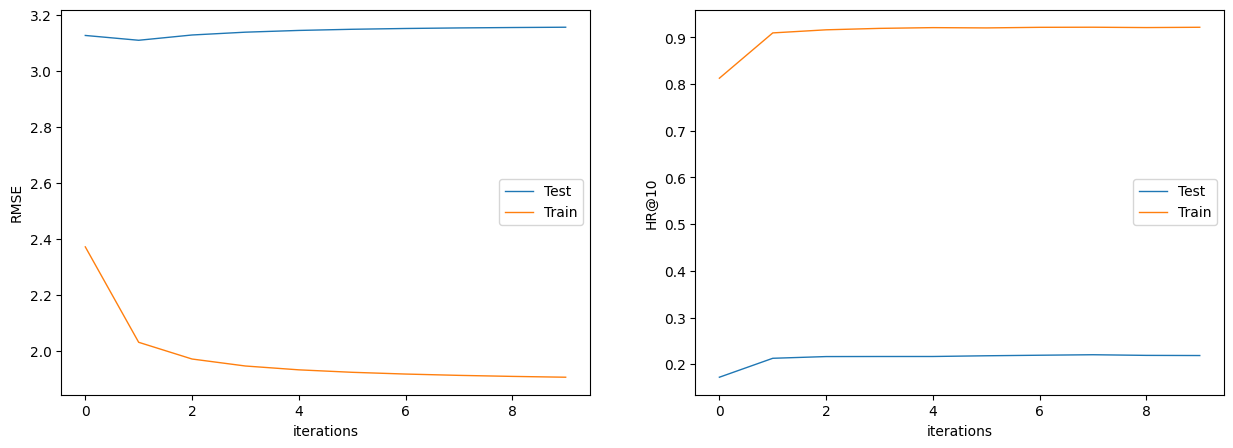

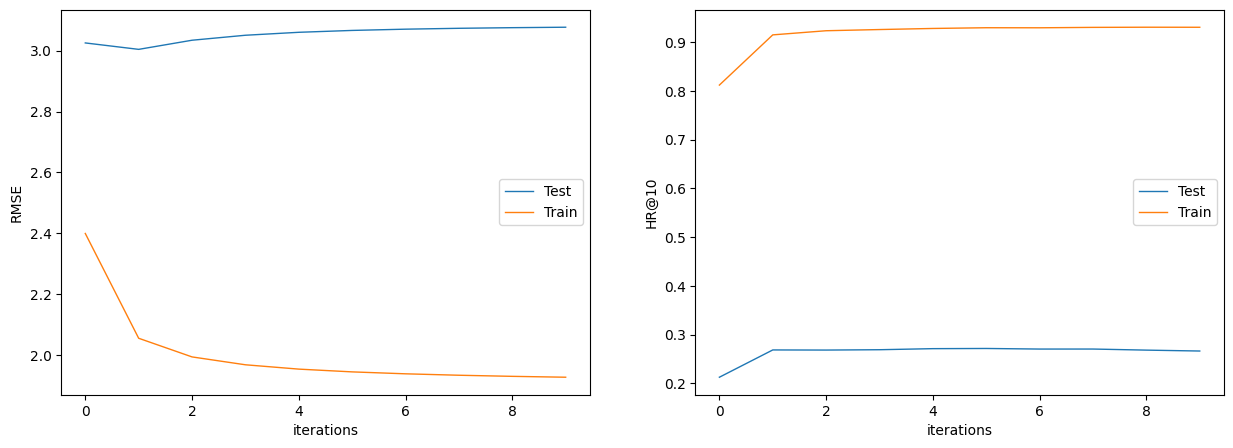

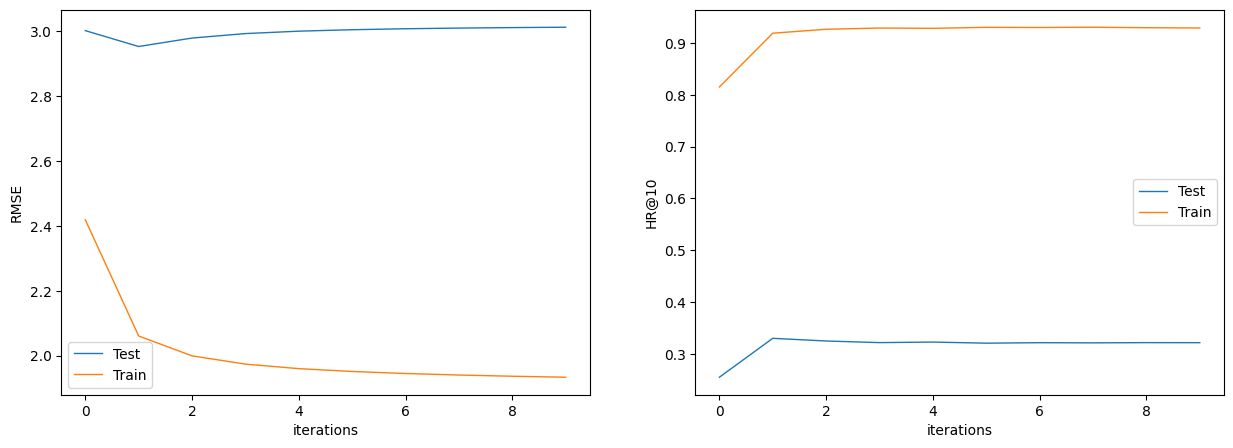

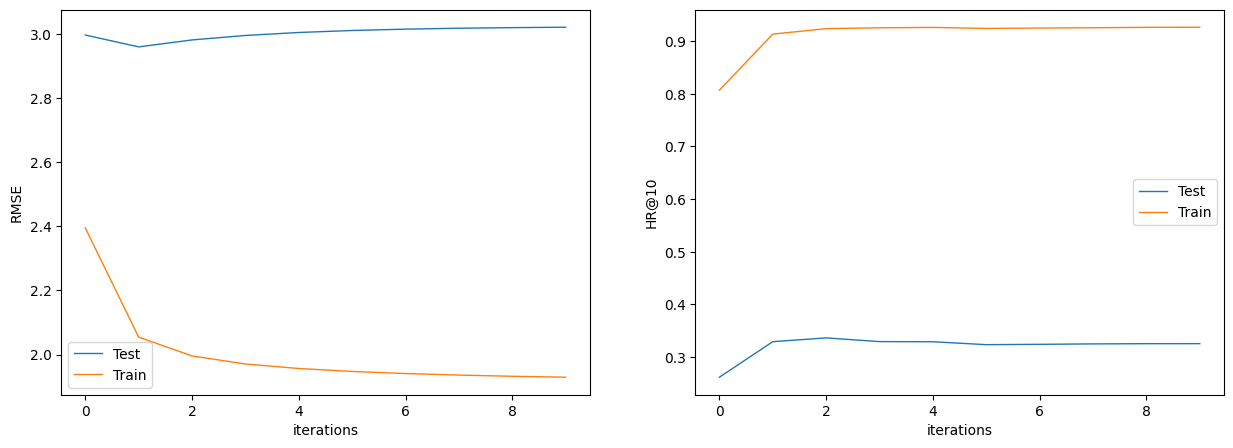

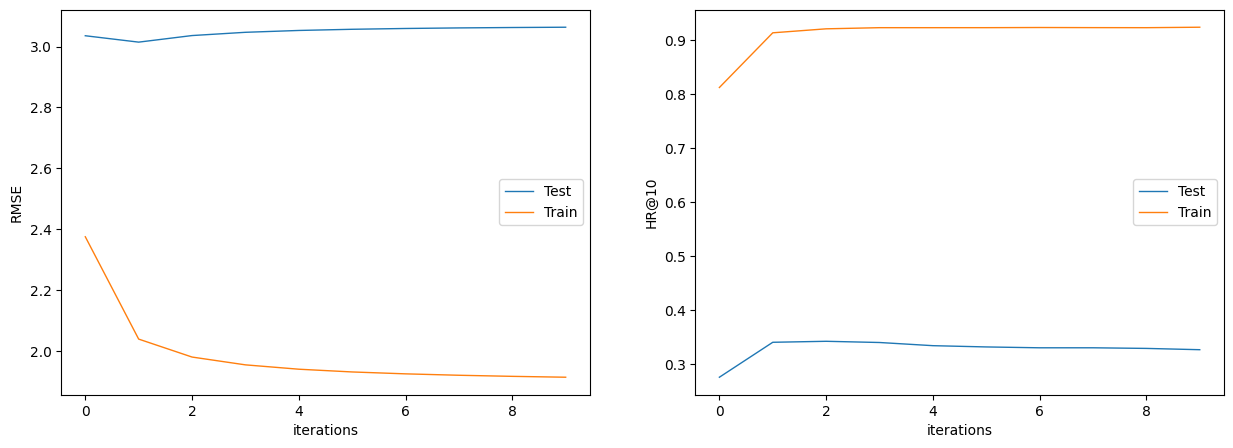

In [7]:
for fold in range(1,6):
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    #YOUR TASK: get train and test R, fit the model, plot learning curve
    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    als = MF_ALS(n_iters = 10, n_factors = 64, reg = 1)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    plot_learning_curve(als)

#### 6. How to modify the above code so that:

We would have ratings {0,1} only instead of {1,2,3,4,5}. What will it change?

## Your Task:
Find appropriate HyperParams of this simple alrogithm by Cross Validation.

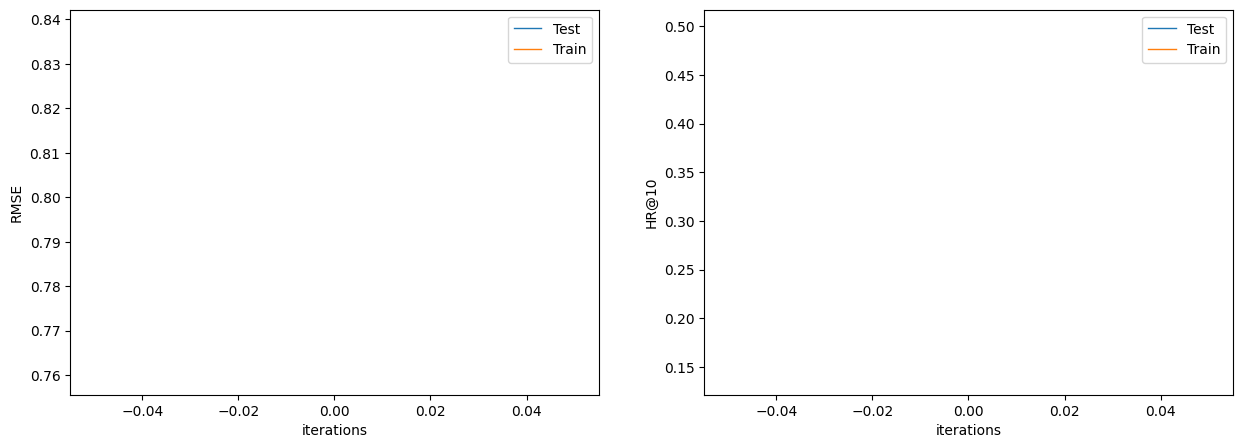

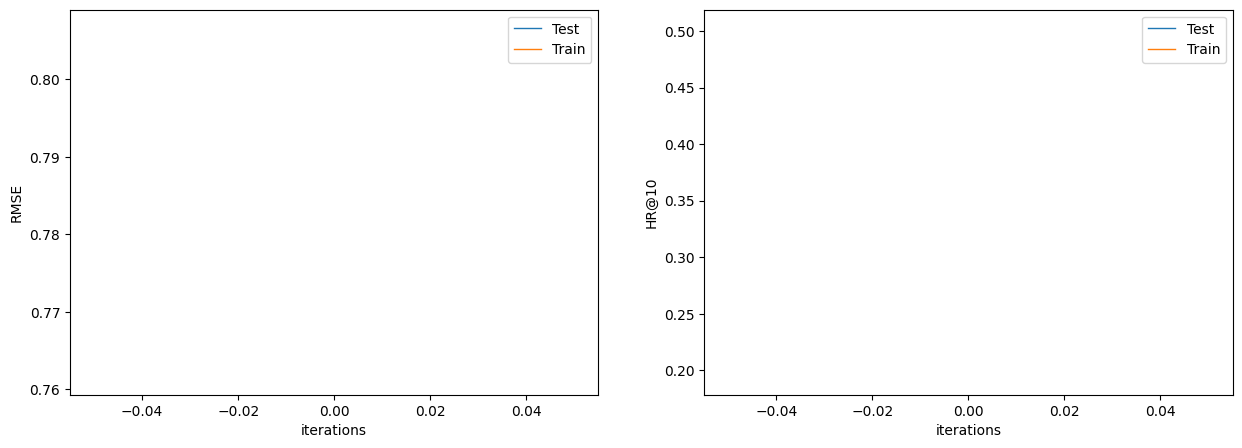

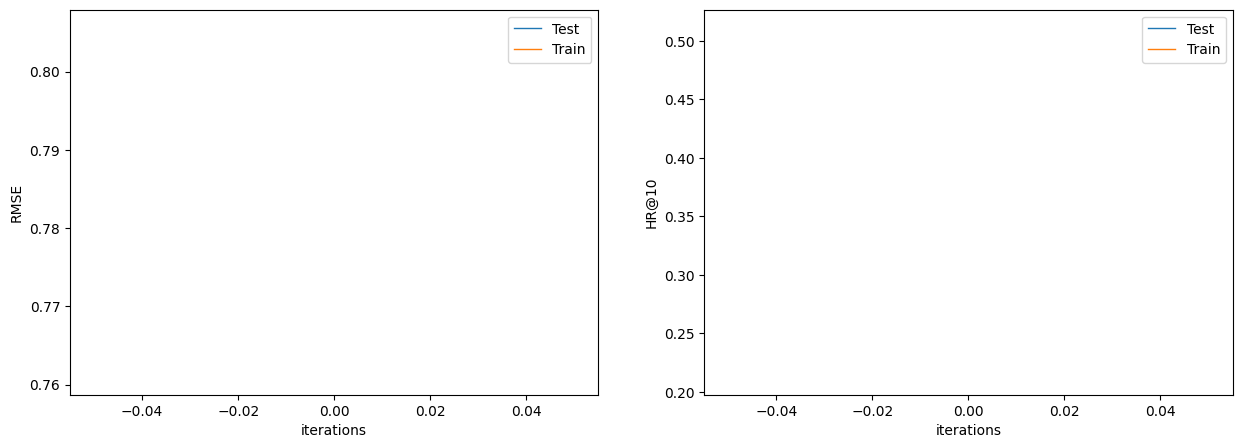

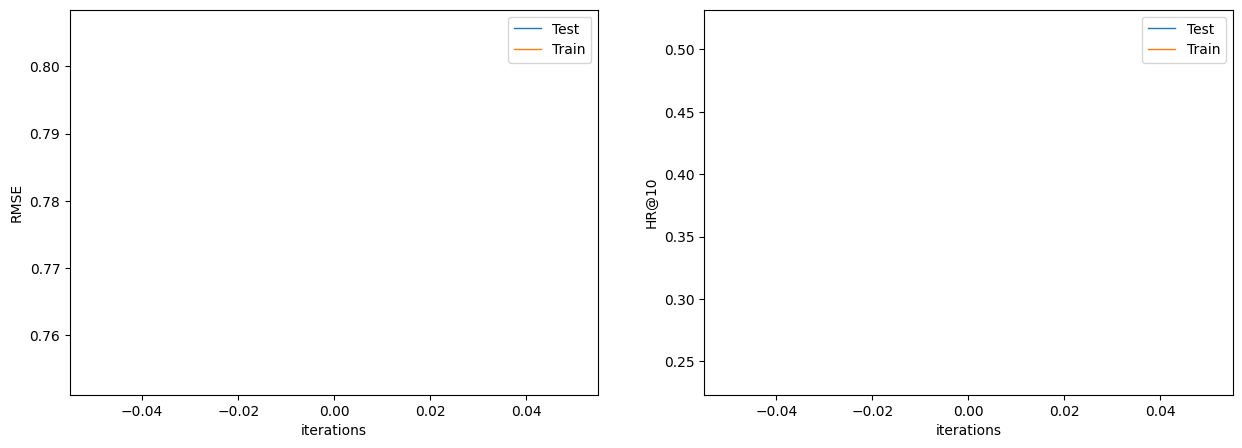

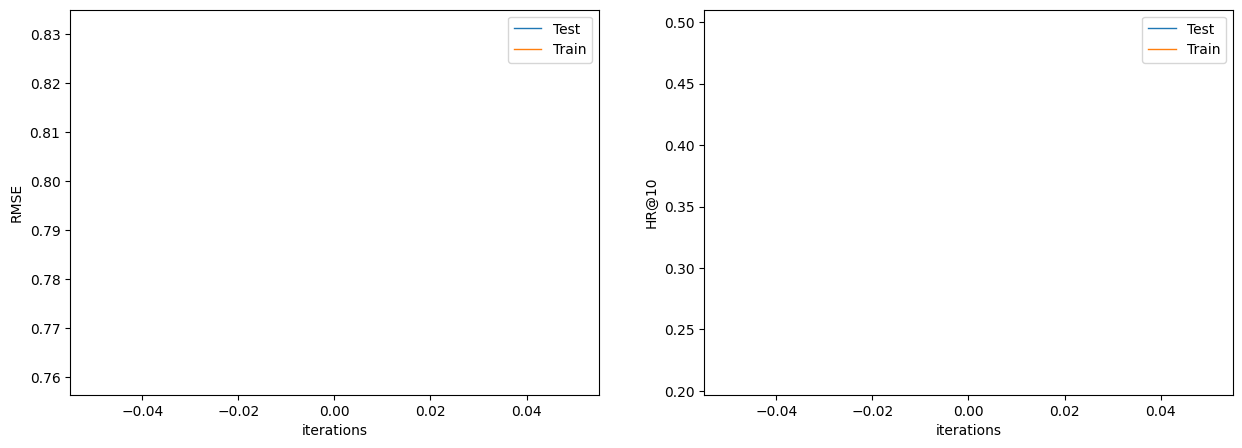

In [8]:

for fold in range(1,6):
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    train_ratings_matrix[train_ratings_matrix>0] = 1
    test_ratings_matrix[test_ratings_matrix>0] = 1
    als = MF_ALS(n_iters = 1, n_factors = 8, reg = 0)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    plot_learning_curve(als)